<a href="https://colab.research.google.com/github/vipu121/PDE_ODE/blob/main/PINN_PDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
def ana_sol(x,y):
  return torch.exp(-x)*(x+torch.pow(y,3))

In [ ]:
def phi_0_y(y):
    return torch.pow(y,3)
def phi_1_y(y):
    t=torch.tensor([[-1.0]]).reshape(1,1)
    return (1+torch.pow(y,3))*torch.exp(t)
def phi_x_0(x):
    return x*torch.exp(-x)
def phi_x_1(x):
    return torch.exp(-x)*(x+1)

In [ ]:
class FCN(nn.Module):
  #Input layer (4 features ) --> Hidden Layer1 --> H2->output
  def __init__(self, n_x,n_y,n_h):
      super(FCN,self).__init__() # to initialize the parameters of base class(nn.Module)
      self.activation =nn.Sigmoid
      self.fc1=nn.Linear(n_x,n_h)
      self.fc2=nn.Linear(n_h,n_h)
      self.fc3=nn.Linear(n_h,n_h)
      self.fc4=nn.Linear(n_h,n_h)
      self.fc5=nn.Linear(n_h,n_h)
      self.fc6=nn.Linear(n_h,n_h)
      self.fc8=nn.Linear(n_h,n_y)

  def forward(self, x,y):
      x=torch.cat((x,y),dim=1)
      x=self.activation()(self.fc1(x))
      x=self.activation()(self.fc2(x))
      x=self.activation()(self.fc3(x))
      x=self.activation()(self.fc4(x))
      x=self.activation()(self.fc5(x))
      x=self.activation()(self.fc6(x))
      x=self.fc8(x)

      return x


In [ ]:
def poission_diff(x,y):
  return torch.exp(-x)*(x-2+torch.pow(y,3)+6*y)

tensor(2.3023, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(7.2878e-05, grad_fn=<AddBackward0>)
tensor(3.3205e-05, grad_fn=<AddBackward0>)
tensor(1.7664e-05, grad_fn=<AddBackward0>)


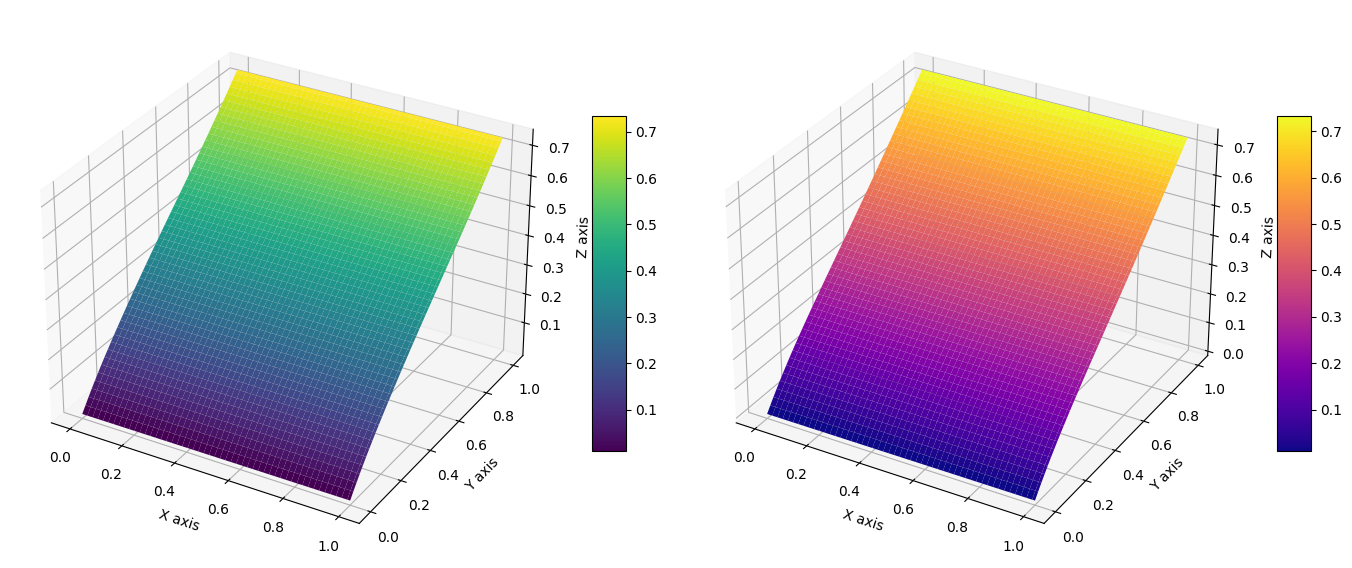

tensor([[2.8014e-06],
        [2.0873e-03],
        [4.9989e-03],
        [8.5876e-03],
        [1.0631e-02],
        [9.5656e-03],
        [6.3085e-03],
        [2.7397e-03],
        [5.6565e-04],
        [1.2907e-03]])


In [ ]:
torch.manual_seed(123)

x_train=torch.linspace(0,1,10,requires_grad=True).reshape(-1,1)
y_train=torch.linspace(0,1,10,requires_grad=True).reshape(-1,1)
pinn=FCN(2,1,50)
optimizer=torch.optim.Adam(pinn.parameters(),lr=0.001)
x_0=torch.zeros_like(x_train)
y_0=torch.zeros_like(x_train)
x_1=torch.ones_like(x_train)
y_1=torch.ones_like(x_train)
lossf=[]
lmbda=1e-4
for i in range(5000):
  optimizer.zero_grad()

  output=pinn.forward(x_train,y_train)

  dO_dx=torch.autograd.grad(output,x_train,torch.ones_like(output),create_graph=True)[0]
  d2O_dx2=torch.autograd.grad(dO_dx,x_train,torch.ones_like(dO_dx),create_graph=True)[0]

  dO_dy=torch.autograd.grad(output,y_train,torch.ones_like(output),create_graph=True)[0]
  d2O_dy2=torch.autograd.grad(dO_dy,y_train,torch.ones_like(dO_dy),create_graph=True)[0]

  f=poission_diff(x_train,y_train)

  loss1=torch.mean((d2O_dx2+d2O_dy2-f)**2)
  # boundary conditions
  loss2=torch.mean((pinn.forward(x_0,y_train)-phi_0_y(y_train))**2)
  loss3=torch.mean(((pinn.forward(x_train,y_0)-phi_x_0(x_train))**2))
  loss4=torch.mean(((pinn.forward(x_1,y_train)-phi_1_y(y_train))**2))
  loss5=torch.mean(((pinn.forward(x_train,y_1)-phi_x_1(x_train))**2))

  loss=lmbda*loss1+loss2+loss3+loss4+loss5
  lossf.append(loss.detach())
  if(i%1000==0):
      print(loss)
  loss.backward()
  optimizer.step()

with torch.no_grad():
  x_train1=torch.linspace(0,1,100).reshape(-1,1)
  y_train1=torch.linspace(0,1,100).reshape(-1,1)
  x=torch.linspace(0,1,100).reshape((100),)
  y=torch.linspace(0,1,100).reshape((100),)
  x, y = np.meshgrid(x, y)
  z=pinn.forward(x_train1,y_train1)
  z1=ana_sol(x_train1,y_train1)
  fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(14, 7))
  surface1 = ax1.plot_surface(x, y, z, cmap='viridis')
  fig.colorbar(surface1, ax=ax1, shrink=0.5, aspect=10)

  ax1.set_xlabel('X axis')
  ax1.set_ylabel('Y axis')
  ax1.set_zlabel('Z axis')
  surface2 = ax2.plot_surface(x, y, z1, cmap='plasma')
  fig.colorbar(surface2, ax=ax2, shrink=0.5, aspect=10)

  ax2.set_xlabel('X axis')
  ax2.set_ylabel('Y axis')
  ax2.set_zlabel('Z axis')
  plt.tight_layout()

  plt.show()
  y_eval=pinn.forward(x_train,y_train)
  y_ana=ana_sol(x_train,y_train)
  print(y_eval-y_ana)
  err=(y_eval-y_ana).numpy().reshape((10),)
  x=x_train.numpy().reshape((10),)
  y=y_train.numpy().reshape((10),)
  z1=ana_sol(x_train,y_train).numpy().reshape((10),)
  z2=y_eval.numpy().reshape((10),)
  # fig = plt.figure()
  # ax = fig.add_subplot(111, projection='3d')
  # ax.plot(x, y, z1, label='3D line')
  # ax.plot(x, y, z2, label='3D line')
  # ax.plot(x, y, err, label='3D line')


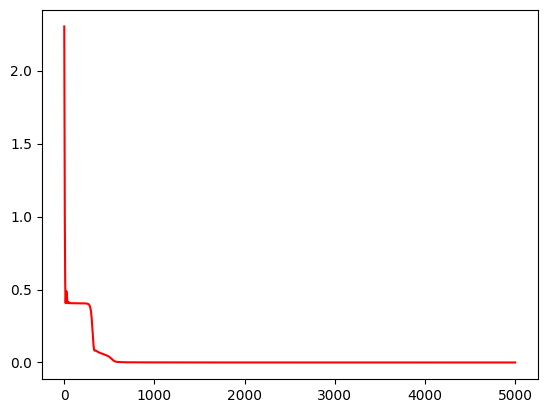

In [ ]:
plt.figure()
plt.plot(lossf,color="red")
plt.show()